# **Text Detection Training**

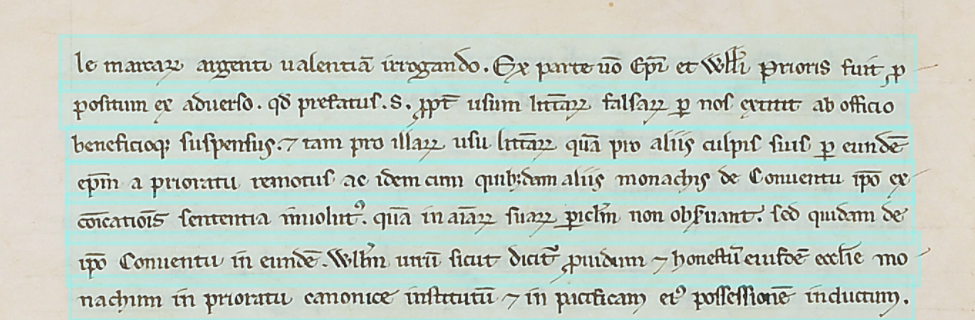

1) Mount colab file system



In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


2) Copy dbnet library on local file system

In [2]:
!cp -r /content/drive/MyDrive/library/DBNet /content/

3) Copy dataset on local file system

In [9]:
!cp -r /content/drive/MyDrive/text_detector_dataset.zip /content/DBNet/

In [11]:
%%capture
!unzip /content/DBNet/text_detector_dataset.zip -d /content/DBNet
!rm -r /content/DBNet/text_detector_dataset.zip

Archive:  /content/DBNet/text_detector_dataset.zip
replace /content/DBNet/text_detector_dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/DBNet/text_detector_dataset/.DS_Store  
  inflating: /content/DBNet/__MACOSX/text_detector_dataset/._.DS_Store  
   creating: /content/DBNet/text_detector_dataset/data/
  inflating: /content/DBNet/text_detector_dataset/data/train.json  
   creating: /content/DBNet/text_detector_dataset/data/train/
  inflating: /content/DBNet/text_detector_dataset/data/val.json  
   creating: /content/DBNet/text_detector_dataset/data/val/
  inflating: /content/DBNet/text_detector_dataset/data/train/051v.jpg  
  inflating: /content/DBNet/text_detector_dataset/data/train/061v.jpg  
  inflating: /content/DBNet/text_detector_dataset/data/train/060r.jpg  
  inflating: /content/DBNet/text_detector_dataset/data/train/060v.jpg  
  inflating: /content/DBNet/text_detector_dataset/data/train/061r.jpg  
  inflating: /content/DBNet/text_detector_data

4) Downlaod pretrained weights

*In your first training, start from general weights (db_base_model.h5)*

In [5]:
!cp /content/drive/MyDrive/dbnet_base_model.h5 /content/

5) Install dependencies

In [12]:
%cd /content/DBNet

/content/DBNet


In [7]:
!python3 -m pip install pyclipper

     |████████████████████████████████| 133kB 5.1MB/s 


**Training Configuration**

1) Compute pixels mean of training set

In [4]:
import glob
import os
import cv2
import numpy as np

#my_path = "/content/datasets/data/train"
training_set_path = '/content/DBNet/text_detector_dataset/data/train'
# Location to move images to
r,g,b = 0,0,0

# Get List of all images
files = glob.glob(training_set_path + '/*.jpg', recursive=True)
for e in files:
  image = cv2.imread(e)
  r_mean = np.mean(np.reshape(image[:,:,0], -1))
  g_mean = np.mean(np.reshape(image[:,:,1], -1))
  b_mean = np.mean(np.reshape(image[:,:,2], -1))
  r+=r_mean
  g+=g_mean
  b+=b_mean

r = r//len(files)
b = b//len(files)
g = g//len(files)

print(r,g,b)

170.0 191.0 203.0


2) Edit file with this parameters: 

1.   computed pixel mean as array eg. [100,100,100]
2.   pretrained weights path
3.   training and validation set path
4.   saving output path


In [ ]:

import os
import os.path as osp
import datetime


class DBConfig(object):

    STEPS_PER_EPOCH = 100

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 20

    # Backbone network architecture
    # Supported values are: ResNet50
    BACKBONE = "ResNet50"


    MEAN = [170.0, 191.0, 203.0]

    # train
    EPOCHS = 50
    INITIAL_EPOCH = 0

    PRETRAINED_MODEL_PATH = '/content/dbnet_base_model.h5'
    LOG_DIR = 'datasets/logs'
    LEARNING_RATE = 1e-4

    CHECKPOINT_DIR = os.path.join('/content/drive/MyDrive/ONORIO_DBWEIGHTS', "checkpoint_weights.{val_loss:.2f}.hdf5")

    # dataset
    IGNORE_TEXT = ["*", "###"]

    TRAIN_DATA_PATH = 'text_detector_dataset/data/train.json'
    VAL_DATA_PATH = 'text_detector_dataset/data/val.json'

    IMAGE_SIZE = 640
    BATCH_SIZE = 8

    MIN_TEXT_SIZE = 8
    SHRINK_RATIO = 0.4

    THRESH_MIN = 0.3 
    THRESH_MAX = 0.7


    def __init__(self):
        """Set values of computed attributes."""

        if not osp.exists(self.LOG_DIR):
            os.makedirs(self.LOG_DIR)


Now you are one step far from training.. open from local file system and update DBnet/config.py with this cell code and restart Google Colab runtime

# **Training**

In [2]:
%cd /content/DBNet

/content/DBNet


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import os.path as osp

from tensorflow.keras import callbacks
from tensorflow.keras import optimizers

from generate import generate
from models.model import DBNet
from config import DBConfig

cfg = DBConfig()

print('Start Training DBNet')
print('dataset path:', cfg.TRAIN_DATA_PATH)
print('pixels mean:', cfg.MEAN)


train_generator = generate(cfg, 'train')
val_generator = generate(cfg, 'val')

model = DBNet(cfg, model='training')

print('pretrained:', cfg.PRETRAINED_MODEL_PATH)
print('output path:', cfg.CHECKPOINT_DIR)

load_weights_path = cfg.PRETRAINED_MODEL_PATH
if load_weights_path:
  print('loading pretrained weights..')
  model.load_weights(cfg.PRETRAINED_MODEL_PATH, by_name=True, skip_mismatch=True)

model.compile(optimizer=optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
              loss=[None] * len(model.output.shape))

# model.compile(optimizer=optimizers.SGD(learning_rate=cfg.LEARNING_RATE, momentum=0.9),
#                loss=[None] * len(model.output.shape))

model.summary()


checkpoint_callback =  callbacks.ModelCheckpoint(
                filepath=cfg.CHECKPOINT_DIR,
                monitor="val_loss",
                save_best_only=True,
                save_weights_only=True,
                verbose=1),
reduce_lr = callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                min_delta=1e-8,
                factor=0.2,
                patience=10,
                verbose=1)
callbacks = [checkpoint_callback,reduce_lr]


model.fit(
    x=train_generator,
    steps_per_epoch=cfg.STEPS_PER_EPOCH,
    initial_epoch=cfg.INITIAL_EPOCH,
    epochs=cfg.EPOCHS,
    verbose=1,
    callbacks=callbacks,
    validation_data=val_generator,
    validation_steps=cfg.VALIDATION_STEPS
)

val = model.evaluate(val_generator,steps=10)
print(val)

Start Training DBNet
dataset path: text_detector_dataset/data/train.json
pixels mean: [170.0, 191.0, 203.0]
pretrained: /content/dbnet_base_model.h5
output path: /content/drive/MyDrive/ONORIO_DBWEIGHTS/checkpoint_weights.{val_loss:.2f}.hdf5
loading pretrained weights..
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_image[0][0]                
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
______________________

# **Evaluate**

Tuning inference.py path to evaluate your trainined model on validation set and check text detection inference

In [5]:
!python3 inference.py

2021-07-13 12:47:59.819331: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-13 12:48:01.584583: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-13 12:48:01.588932: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-13 12:48:01.589036: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 43240f725f84
2021-07-13 12:48:01.589051: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 43240f725f84
2021-07-13 12:48:01.589154: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.32.3
2021-07-13 12:48:01.589194: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.32.3
2021-07-13 12:48:01.589216: I tensorflow/st

Show inference's result

# **Debug Dataset Annotation**

run this code to check quality of annotations

In [1]:
import glob
import cv2
import json
import numpy as np
import os

gt_train_path = '/content/DBNet/text_detector_dataset/data/train.json'
gt_val_path = '/content/DBNet/text_detector_dataset/data/train.json'

if not os.path.isdir('check_gt'):
  os.mkdir('check_gt')

with open(gt_train_path) as gt_train:

    gt_json = json.load(gt_train)
    #data_list = gt_json['data_list']

    for data in gt_json['data_list']:
        filename = data['img_name']
        img = cv2.imread('/content/DBNet/text_detector_dataset/data/train/' + filename)
        h, w = img.shape[:2]
        print(filename, h, w)
        for i, ann in enumerate(data['annotations']):
            pts = ann['polygon']
            poly = np.array(ann['polygon']).astype(np.int32)
            #cv2.drawContours(image, np.expand_dims(poly, axis=0), -1, (0, 255, 0), 2)
            color = (255, 0, 0)
            thickness = 2
            isClosed = True          
            resized_image = cv2.polylines(img, [poly], isClosed, color, thickness)

        cv2.imwrite(os.path.join('/content/gt/',filename), img)

'''
with open(gt_val_path) as gt_val:

    gt_json = json.load(gt_val)
    #data_list = gt_json['data_list']

    for data in gt_json['data_list']:
        filename = data['img_name']
        img = cv2.imread('datasets/data/val/' + filename)
        h, w = img.shape[:2]
        print(filename, h, w)
        for i, ann in enumerate(data['annotations']):
            pts = ann['polygon']
            poly = np.array(ann['polygon']).astype(np.int32)
            #cv2.drawContours(image, np.expand_dims(poly, axis=0), -1, (0, 255, 0), 2)
            color = (255, 0, 0)
            thickness = 2
            isClosed = True          
            resized_image = cv2.polylines(img, [poly], isClosed, color, thickness)

        cv2.imwrite(os.path.join('check_gt',filename), img)
'''

051v.jpg 2496 1984
052v.jpg 2496 1984
053r.jpg 2496 1984
053v.jpg 2496 1984
054r.jpg 2496 1984
054v.jpg 2496 1984
055v.jpg 2496 1984
056v.jpg 2496 1984
057r.jpg 2496 1984
058r.jpg 2496 1984
058v.jpg 2496 1984
059r.jpg 2496 1984
059v.jpg 2496 1984
060r.jpg 2496 1984
060v.jpg 2496 1984
061r.jpg 2496 1984
061v.jpg 2496 1984
062r.jpg 2496 1984
062v.jpg 2496 1984


"\nwith open(gt_val_path) as gt_val:\n\n    gt_json = json.load(gt_val)\n    #data_list = gt_json['data_list']\n\n    for data in gt_json['data_list']:\n        filename = data['img_name']\n        img = cv2.imread('datasets/data/val/' + filename)\n        h, w = img.shape[:2]\n        print(filename, h, w)\n        for i, ann in enumerate(data['annotations']):\n            pts = ann['polygon']\n            poly = np.array(ann['polygon']).astype(np.int32)\n            #cv2.drawContours(image, np.expand_dims(poly, axis=0), -1, (0, 255, 0), 2)\n            color = (255, 0, 0)\n            thickness = 2\n            isClosed = True          \n            resized_image = cv2.polylines(img, [poly], isClosed, color, thickness)\n\n        cv2.imwrite(os.path.join('check_gt',filename), img)\n"